In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor



testdata= pd.read_csv('data/test.csv')
traindata= pd.read_csv('data/train.csv')

In [4]:
traindata1 = traindata.select_dtypes(exclude=['object'])
trainx=traindata1[["OverallQual","GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "YearBuilt"]]
trainy=traindata1["SalePrice"]

testdata1 = testdata.select_dtypes(exclude=['object'])
testx=testdata1[["OverallQual","GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "YearBuilt"]]


In [20]:
RFregres=RandomForestRegressor(n_estimators=100,
    max_depth=15,
    min_samples_split=5,    
    min_samples_leaf=3,      
    random_state=42)
RFregres.fit(trainx,trainy)
pred=RFregres.predict(testx)

# 3. Create submission file for Kaggle
submission = pd.DataFrame({
    'Id': testdata.Id,
    'SalePrice': pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


In [21]:
# Train-test split for direct comparison
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(trainx, trainy, test_size=0.2, random_state=42)

# Train the model
RFregres.fit(X_train, y_train)

# Calculate metrics on both sets
train_pred = RFregres.predict(X_train)
val_pred = RFregres.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Training R2: {train_r2:.3f}")
print(f"Validation R2: {val_r2:.3f}")

Training RMSE: 20676.01
Validation RMSE: 32960.11
Training R2: 0.928
Validation R2: 0.858


In [22]:
# Create 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate RMSE scores
mse_scores = cross_val_score(RFregres, trainx, trainy, 
                           scoring='neg_mean_squared_error', 
                           cv=kf)
rmse_scores = np.sqrt(-mse_scores)

# Calculate R2 scores
r2_scores = cross_val_score(RFregres, trainx, trainy, 
                          scoring='r2', 
                          cv=kf)

# Print results
print("\nRMSE scores for each fold:")
for i, score in enumerate(rmse_scores, 1):
    print(f"Fold {i}: {score:.2f}")
print(f"\nAverage RMSE: {rmse_scores.mean():.2f}")

print("\nR2 scores for each fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nAverage R2: {r2_scores.mean():.3f}")


RMSE scores for each fold:
Fold 1: 37021.13
Fold 2: 29494.51
Fold 3: 26273.95
Fold 4: 32132.58
Fold 5: 40238.59
Fold 6: 40220.69
Fold 7: 33878.29
Fold 8: 29053.75
Fold 9: 29146.19
Fold 10: 25924.82

Average RMSE: 32338.45

R2 scores for each fold:
Fold 1: 0.850
Fold 2: 0.859
Fold 3: 0.876
Fold 4: 0.871
Fold 5: 0.682
Fold 6: 0.727
Fold 7: 0.841
Fold 8: 0.841
Fold 9: 0.834
Fold 10: 0.874

Average R2: 0.826


In [23]:
xgb=XGBRegressor(n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,              # Limit tree depth to prevent dominance of one feature
    colsample_bytree=0.7,     # Use only 70% of features in each tree
    subsample=0.8,            # Use 80% of training instances per tree
    min_child_weight=5,       # Require more observations per node
    gamma=1,                  # Increase regularization
    reg_lambda=2              # L2 regularization
)
xgb.fit(trainx,trainy)
pred=xgb.predict(testx)

In [24]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_predict
import numpy as np

# Cross-validation to get predictions on training data
cv_predictions = cross_val_predict(xgb, trainx, trainy, cv=5)

# Calculate metrics
r2 = r2_score(trainy, cv_predictions)
rmse = np.sqrt(mean_squared_error(trainy, cv_predictions))

print(f"Cross-validated R² Score: {r2:.4f}")
print(f"Cross-validated RMSE: {rmse:.4f}")

Cross-validated R² Score: 0.8361
Cross-validated RMSE: 32146.2505


Top Features by Importance:
       Feature  Importance
0  OverallQual    0.750485
1    GrLivArea    0.097413
3  TotalBsmtSF    0.041778
2   GarageArea    0.038732
5    YearBuilt    0.037941
4     1stFlrSF    0.033651


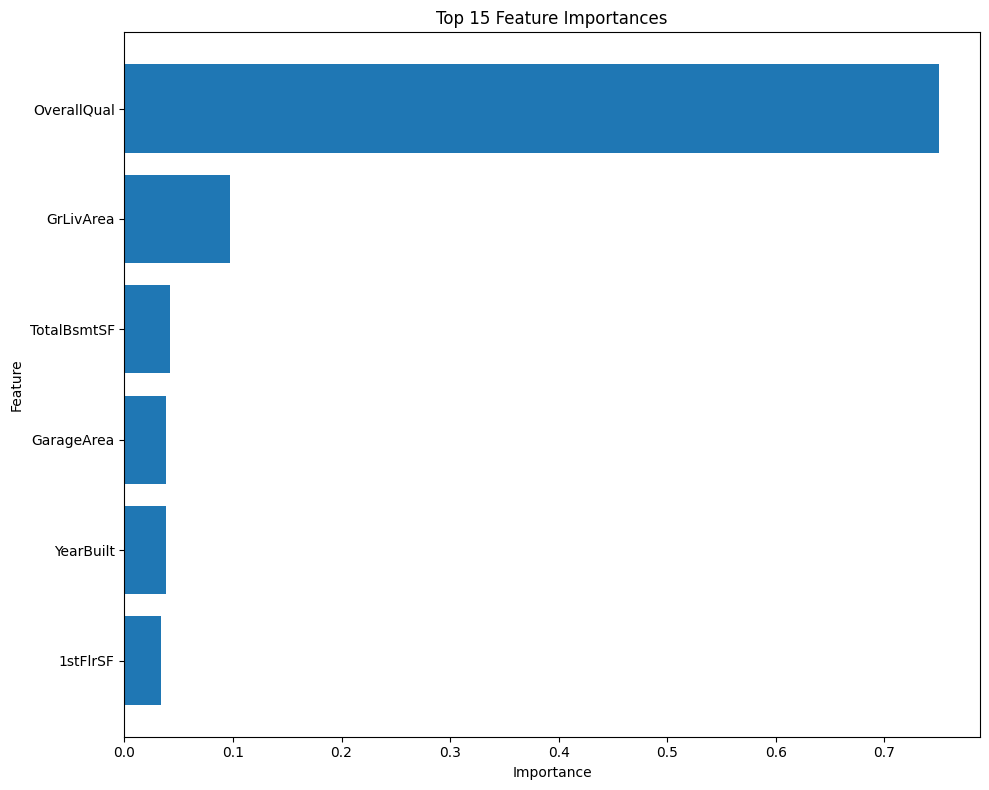

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importance = xgb.feature_importances_

# Create a DataFrame for better visualization
# Assuming trainx is a DataFrame with column names
feature_names = trainx.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print top features
print("Top Features by Importance:")
print(importance_df.head(15))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

Top Features by Importance (Balanced Model):
       Feature  Importance
0  OverallQual    0.263116
1    GrLivArea    0.191516
2  TotalBsmtSF    0.150883
3   GarageArea    0.144963
4    YearBuilt    0.127707
5     1stFlrSF    0.121815


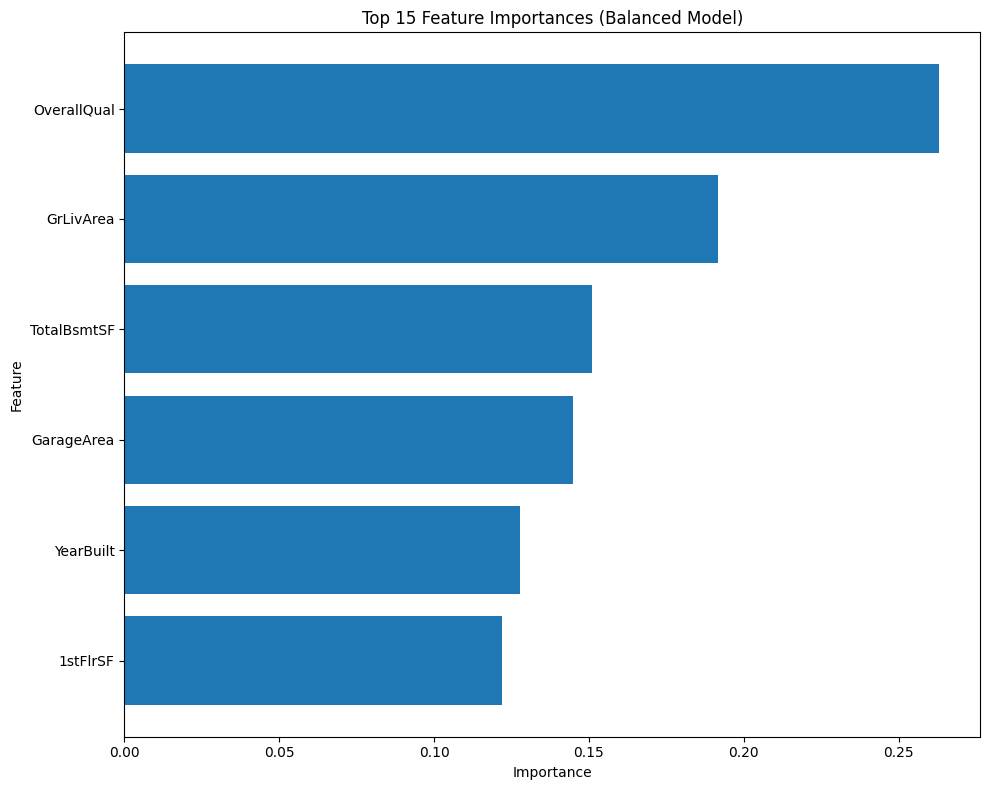

Cross-validated R² Score: 0.8054
Cross-validated RMSE: 35034.4546


In [26]:
# Define a new model with adjusted parameters
balanced_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,           # Reduced to limit dominant feature impact
    max_depth=4,                  # Further reduced to prevent deep trees
    colsample_bytree=0.2,         # Very aggressive feature sampling
    colsample_bylevel=0.2,        # Add level-wise feature sampling
    colsample_bynode=0.2,         # Add node-wise feature sampling
    subsample=0.2,                # More aggressive row sampling
    min_child_weight=10,          # Even more conservative splits
    gamma=5,                      # Much higher minimum loss reduction
)

# Train the new model
balanced_xgb.fit(trainx, trainy)

# Get feature importances from the NEW model
feature_importance = balanced_xgb.feature_importances_

# Create DataFrame and visualize as before
feature_names = trainx.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
print("Top Features by Importance (Balanced Model):")
print(importance_df.head(15))

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances (Balanced Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Cross-validation to get predictions on training data
cv_predictions = cross_val_predict(balanced_xgb, trainx, trainy, cv=5)

# Calculate metrics
r2 = r2_score(trainy, cv_predictions)
rmse = np.sqrt(mean_squared_error(trainy, cv_predictions))

print(f"Cross-validated R² Score: {r2:.4f}")
print(f"Cross-validated RMSE: {rmse:.4f}")